In [1]:
%matplotlib inline
import string
import cartopy.crs as ccrs
import pjr
import numpy as np
from timeit import default_timer as timer
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import cdms2
import cdutil
import re


pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None, time=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1, time=time)            # extract fields, remove dimensions length one
    if vname is "TREFHT":
        F = F - 273.15
        F.units = "C"
    if vname is "TGCLDIWP":
        F = F*1.e3
        F.units = 'g/m2'
    if vname is "TGCLDLWP":
        F = F*1.e3
        F.units = 'g/m2'
        
    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    F.id = vname
    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
from matplotlib import gridspec
def setup3 ():
    fig = plt.figure(figsize=(6, 9)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Robinson())
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    ax1 = plt.subplot(gs[2],projection=ccrs.Robinson())
    ax1.set_global() # make axis consistent with projection limits
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.Robinson())
    ax2.set_global() # make axis consistent with projection limits
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def setup1 ():
    fig = plt.figure(figsize=(6, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Robinson())
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    return fig,ax0,cx0;

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;


def pltframe (data, lons=None, lats=None, axo=None, cxo=None,plotOpt=None):
    """Create a robinson projection contour plot of one variable
    axo = the axes that we make the plot on 
    data = 2d numpy array (or data structure base on numpy) ordered (latitude, pressure
)
    lons = optional mesh  of longitude (same shape as data)
    lats = 1d numpy array of latitudes (")
    plotOpt is a optional dictionary with plotting options:
      'scale_factor': multiply values with this factor before plotting
      'units': a units label for the colorbar
      'clevs': use list of values as contour intervals
      'cmap': the color map to use
      'cabv': the above color
      'cbel': the below color
      'colorbar': location of colorbar ('bot','top','left','right','None')
      'rmClev': contour level to delete; frequently Zero, see findNiceContours
      'title': a title for the plot
    """
    print "pltframe"
    if plotOpt is None: plotOpt = {}
    clevs = plotOpt.get("clevs") 
    print "pltframe plotOpt clevs", clevs
    rmClev = plotOpt.get("rmClev")
#    print "pltframe rmClev", rmClev
    if clevs is None:
        print "clevs undefined"
        clevs = pjr.findNiceContours(data,rmClev=rmClev)
    print "data range",data.min(), data.max()
    print "pltframe final clevs", clevs
    cmap = plotOpt.get("cmap")
    if cmap is None:
        cmap = mpl.cm.get_cmap()
    norm = mpl.colors.BoundaryNorm(clevs,cmap.N)
    scale_factor = plotOpt.get('scale_factor', 1.0)
    pdata = data * scale_factor
    # add a title
    title = defset(data, plotOpt,"title")
    if not title is None: axo.set_title(title,loc='center')
    ltitle = defset(data, plotOpt,"ltitle")
    if not ltitle is None: axo.set_title(ltitle,loc='left')
    rtitle = defset(data, plotOpt,"rtitle")
    if not rtitle is None: axo.set_title(rtitle,loc='right')
    conout = axo.contourf(lons, lats, pdata, levels=clevs, 
        norm=norm, cmap=cmap, transform=ccrs.PlateCarree(),extend='both')
    noCbar = plotOpt.get("noCbar")
    if noCbar is None:
        cabv = plotOpt.get("cabv",'green') 
        conout.cmap.set_over(cabv)
        cbel = plotOpt.get('cbel','grey')
        conout.cmap.set_under(cbel)
        cbar = fig.colorbar(conout, cax=cxo,  orientation="vertical",ticks=clevs)
        labelFontSize = "small"
        units = defset(data, plotOpt,"units")
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(labelFontSize)
            #cbar.set_label(units)
        if not units is None: cbar.ax.set_title('('+units+')',pad=5)
    else:
        cxo.axis('off')
 
    axo.coastlines()
    axo.gridlines()
    print"pltframe done"

def pltdat(T1, T2, DT):
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()
    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

def pltdat1(T1, T2, DT):
#   just do one frame
    cmap = plt.cm.viridis
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
#    pltframe(T2, lons, lats, ax3[0], cx3[0], 
#             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

#    pltframe(T1, lons, lats, ax3[1], cx3[1], 
#             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})
    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dtitle = ltitD
    pltframe(DT, lons, lats, ax1, cx1, 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})


seas JAN
jname1 /global/cscratch1/sd/pjr/HW_e3sm_v1_PD_LR_regrid/e3sm_v1_PD_LR.cam.h1.1997-12-31-00000.nc
jname2 /global/cscratch1/sd/rdzhang/MERRA2/inst6_3d_ana_Nv/MERRA2_200.inst6_3d_ana_Nv.19980101.nc4
g2 varlist ['PS', 'QV', 'DELP', 'U', 'T', 'V', 'O3']
g2 dims ['lat', 'lev', 'lon', 'time']
processing E3SM 
figure being saved to  workdir/TMQ.pdf
processing MERRA2
range 0.33423877224279863 76.82421074371695
plotting MERRA2
pltframe
pltframe plotOpt clevs [ 0. 10. 20. 30. 40. 50. 60. 70.]
data range 0.33423877224279863 76.82421074371695
pltframe final clevs [ 0. 10. 20. 30. 40. 50. 60. 70.]
pltframe done
plotting E3SM
pltframe
pltframe plotOpt clevs [ 0. 10. 20. 30. 40. 50. 60. 70.]
data range 0.052404914 70.45588
pltframe final clevs [ 0. 10. 20. 30. 40. 50. 60. 70.]
pltframe done
DT.id TMQ
pltframe
pltframe plotOpt clevs [-30. -25. -20. -15. -10.  -5.   5.  10.  15.  20.  25.  30.]
data range -27.027976524230695 32.007237634720354
pltframe final clevs [-30. -25. -20. -15. -10.  -5.

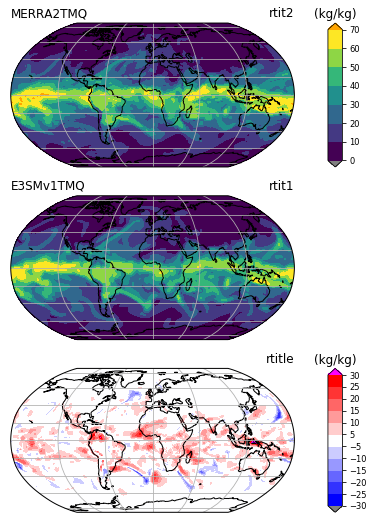

NameError: name 'i' is not defined

In [8]:
# a cell in preparation to do the real model intercomparison
# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list

#vlist.append(vsets('TGCLDLWP', 'TGCLDLWP','TGCLDLWP'))
#vlist.append(vsets('TGCLDIWP', 'TGCLDIWP','TGLDLIWP'))

#vlist.append(vsets("FSNT", "FSNT","FSNT"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
vlist.append(vsets("TMQ", "TMQ","TMQ"))
#vlist.append(vsets("SST", "SST","SST"))
#vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
#vlist.append(vsets("FLNT", "FLNT","FLNT"))
#vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
#vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))
#vlist.append(vsets('LWCF', 'LWCF','LWCF'))
#vlist.append(vsets("Aer Opt Depth", "AEROD_v","AEROD_v"))
#vlist.append(vsets("Solar Insolation", "SOLIN", "SOLIN"))
#vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
#vlist.append(vsets('SWCF', 'SWCF','SWCF'))
#vlist.append(vsets('CLDTOT', 'CLDTOT','CLDTOT'))
#vlist.append(vsets('CLDLOW', 'CLDLOW','CLDLOW'))
#vlist.append(vsets('CLDMED', 'CLDMED','CLDMED'))
#vlist.append(vsets('CLDHGH', 'CLDHGH','CLDHGH'))

def nameSort(e):
    return e.name

vlist.sort(key=nameSort)

#vlist.append(vsets("Precipitation", "PRECL","PRECL"))
#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["JAN"]


for seas in seaslist:
    print "seas", seas

    # model1 dataset  
    dir1 = "/global/cscratch1/sd/pjr/HW_e3sm_v1_PD_LR_regrid/"
#    f1 = "e3sm_v1_PD_LR.cam.h0.1997-12.nc"
    f1 = "e3sm_v1_PD_LR.cam.h1.1998-01-03-64800.nc" 
    f1 = "e3sm_v1_PD_LR.cam.h1.1998-01-26-21600.nc"
    f1 = "e3sm_v1_PD_LR.cam.h1.1997-12-31-00000.nc"
    title1 = "E3SMv1"
    vname = "TMQ"
    
    ltit1 = title1+vname
    rtit1 = 'rtit1'
  
    jname1 = dir1+f1
    g1 = cdms2.open(jname1);
    print "jname1", jname1
    varlist = g1.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
#    print "g1 varlist", varlist
#    dims = g1.listdimension();

    # model2 dataset
    dir2 = "/global/cscratch1/sd/rdzhang/MERRA2/inst6_3d_ana_Nv/"
    f2 = "MERRA2_200.inst6_3d_ana_Nv.19980101.nc4"
    title2 = "MERRA2"
    ltit2 = title2+vname  
    rtit2 = "rtit2"
    
    jname2 = dir2+f2
    g2 = cdms2.open(jname2);
    print "jname2", jname2  

    varlist2 = g2.listvariables();
#   varlist = [x for x in varlist if re.match(r'^.*CLD.*',x)]
    print "g2 varlist", varlist2
    dims2 = g2.listdimension();
    print "g2 dims", dims2
    
    fig, ax3, cx3 = setup3()
    
    print "processing E3SM "
    T1 = getfld(g1,"TMQ")
#    print "T1 axislist", T1.getAxisList()
    timeunits = T1.getTime().units
#    print "timeunits", timeunits
    import cdtime
    ct = cdtime.comptime(1998,1,1)
    rt = ct.torel(timeunits)
#    print "relative time of 1998-01-01 is", rt.value
    T1 = getfld(g1,"TMQ",time=rt.value)

#    print "x0", T1.shape

    pltname = "workdir/TMQ.pdf"
    lons = T1.getLongitude()
    lats = T1.getLatitude()
#   pltframe(T1, lons, lats, ax3[1], cx3[1])# , 
    #plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

    print "figure being saved to ", pltname

    print "processing MERRA2"
    
    T2 = getfld(g2,"QV")
    DELP = getfld(g2,'DELP')
    T2V = T2*DELP/9.806

    T2V = cdutil.averager(T2V,axis="t",weights='unweighted')
    T2V = cdutil.averager(T2V,axis="z",weights='equal', action='sum')
    print "range", T2V.min(), T2V.max()
    
#    pltframe(T2V, lons, lats, ax3[0], cx3[0]) 
    
    T2 = T2V    
    DT = T2 - T1
    DT.id = T1.id

#    pltframe(DT, lons, lats, ax3[2], cx3[2]) #, 
    #  plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})    


    cmap = plt.cm.viridis

    print "plotting MERRA2"
#    print TP0.info()
    dtrng = np.array([T1.min(),T2.min(),T1.max(), T2.max()])
    clevs = pjr.findNiceContours(dtrng)
    
    pltframe(T2, lons, lats, ax3[0], cx3[0], 
             plotOpt={'cmap':cmap,'ltitle':ltit2,'clevs':clevs,'rtitle':rtit2,'cbel':'grey','cabv':'orange'})

    print "plotting E3SM"
    pltframe(T1, lons, lats, ax3[1], cx3[1], 
             plotOpt={'ltitle':ltit1,'rtitle':rtit1,'clevs':clevs,'cmap':cmap,'cbel':'grey','cabv':'magenta','noCbar':True})

    cmap = pjr.diverge_map()
    dlevs = pjr.findNiceContours(DT,nlevs=12,rmClev=0.,sym=True)
#    print "T1.info", T1.info()
#    print "DT info", DT.info()

    print "DT.id", DT.id
    if DT.id == 'LWCF':
        dlevs = [-5.,-4.,-3.,-2.,-1.,1.,2.,3.,4.,5.]
    if DT.id == 'SWCF':
        dlevs = [-10.,-8.,-6.,-4.,-2.,2.,4.,6.,8.,10.]
    if DT.id == 'TS':
        dlevs = [-1.,-0.8,-0.6,-0.4,-0.2,0.2,0.4,0.6,0.8,1.]
    if DT.id == 'TGCLDIWP':
        dlevs = [-5.,-2.,-1.,1.,2.,5.]
    if DT.id == 'FSNT':
        dlevs = [-15.,-10.,-5.,-2.,-1.,1.,2.,5.,10.,15.]
        
    dtitle = ""
    rtitD = "rtitle"
    pltframe(DT, lons, lats, ax3[2], cx3[2], 
             plotOpt={'ltitle':dtitle,'rtitle':rtitD,'clevs':dlevs,'cmap':cmap,'cbel':'grey','cabv':'magenta'})

    
    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    x = plt.show()
    print "done with"+i.name+"\n\n\n"
#    1./0.
    1./0.



In [ ]:
    for i in vlist:
        fig, ax3, cx3 = setup3()
        #fig, ax1, cx1 = setup1()
        vname = i.mname
        print "i", vname
        ltit1 = title1+vname
        ltit2 = title2+vname
        ltitD = title2+"-"+title1
        
        pltname = "workdir/Test_Roblatlon_"+i.mname+"_"+seas+"_FDIFS.pdf"
        LF1 = getfld(g1,"LANDFRAC")
        OF1 = getfld(g1,"OCNFRAC")
        IF1 = getfld(g1,"ICEFRAC")
#       print "LF1 range", LF1.min(), LF1.max()

        T1 = getfld (g1, vname)
#       print " loop T1.info", T1.info()

        GA1 = cdutil.averager(T1,axis="xy")

        T2 = getfld (g2, vname)
        if T1.shape != T2.shape:
            print "T1 and T2 shapes differ", T1.shape, T2.shape
            1./0.
            
        LF2 = getfld(g2,"LANDFRAC")
        OF2 = getfld(g2,"OCNFRAC")
        IF2 = getfld(g2,"ICEFRAC")
        LLW1 = cdutil.area_weights(T1)[:] #lat lon weights
        LLLW1 = LLW1*LF1; LLLW1 = LLLW1/LLLW1.sum(); # Land weights sum to one over land pts
        OLLW1 = LLW1*OF1; OLLW1 = OLLW1/OLLW1.sum(); # Ocean weights sum to one over ocean pts
        ILLW1 = LLW1*IF1; ILLW1 = ILLW1/ILLW1.sum(); # Sea Ice weights sum to one over ice pts
        latlonwts = cdutil.area_weights(T1)[:]
#        print "shape", latlonwts.shape
#        print "range", latlonwts.min(), latlonwts.max()
#        print "sum", latlonwts.sum()
#        print "GA using latlonwts", cdutil.averager(T1,axis="xy",weights=latlonwts)
#        llw2 = latlonwts*LF1
#        llw2 = llw2/llw2.sum()
#        print "llw2 sum", llw2.sum()
        print "land only GA1", cdutil.averager(T1,axis="xy",weights=LLLW1)
        print "ocean only GA1", cdutil.averager(T1,axis="xy",weights=OLLW1)
        print "sea ice only GA1", cdutil.averager(T1,axis="xy",weights=ILLW1)
#        print "latlonwts shape and range", dir(latlonwts)# .shape() #, latlonwts.min(), latlonwts.max()

        maskon = False
        if maskon is True:
            print "***** MASKING T1"
            mlist = (LF1[:] < 0.5) # mask out values less than this number
            mlist = (IF1[:] < 0.1) # mask out values less than this number
            mlist = (OF1[:] < 1.) # mask out values less than this number
#            print "mlist",mlist[0,0],mlist[-1,-1]
#            print "mask shape", mlist.shape
            T1.mask = mlist # add a mask
            ltit1 = ltit1 + " masked"
            print "global average after a mask is added", cdutil.averager(T1,axis="xy")
            print "global average in land region after a mask is added", cdutil.averager(T1,axis="xy",weights=LLLW1)
            print "global average in ocean region after a mask is added", cdutil.averager(T1,axis="xy",weights=OLLW1)
            print "global average in ice region after a mask is added", cdutil.averager(T1,axis="xy",weights=ILLW1)
            print "***** MASKING T2"
            mlist = (LF2[:] < 0.5) # mask out values less than this number
            mlist = (IF2[:] < 0.1) # mask out values less than this number
            mlist = (OF2[:] < 1.) # mask out values less than this number
#            print "mlist",mlist[0,0],mlist[-1,-1]
#            print "mask shape", mlist.shape
            T2.mask = mlist # add a mask
            print "global average after a mask is added", cdutil.averager(T2,axis="xy")
            print "global average in land region after a mask is added", cdutil.averager(T2,axis="xy",weights=LLLW1)
            print "global average in ocean region after a mask is added", cdutil.averager(T2,axis="xy",weights=OLLW1)
            print "global average in ice region after a mask is added", cdutil.averager(T2,axis="xy",weights=ILLW1)
            ltit2 = ltit2 + " masked"

        GA1 = cdutil.averager(T1,axis="xy")
        GA2 = cdutil.averager(T2,axis="xy")
        rtit1 = "Gl. Avg. %6.2f"%GA1
        rtit2 = "Gl. Avg. %6.2f"%GA2
        print "land only GA2", cdutil.averager(T2,axis="xy",weights=LLLW1)
        print "ocean only GA2", cdutil.averager(T2,axis="xy",weights=OLLW1)
        print "sea ice only GA2", cdutil.averager(T2,axis="xy",weights=ILLW1)

        DT = T2 - T1
        DT.id = T1.id

        
        DG = GA2 - GA1
        print "GA1, GA2, DG", GA1, GA2, DG
        rtitD = i.mname+" $\Delta$ Gl. Avg. %6.2f"%DG

        pltdat1(T1, T2, DT)
        

        print "figure being saved to ", pltname
        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        x = plt.show()
        print "done with"+i.name+"\n\n\n"
#       break


In [ ]:
    # model2 dataset
    dir1 = '/global/cscratch1/sd/leebrent/climos/output/20161118.beta0.F1850COSP.ne30_ne30.edison/'
    f1 = '20161118.beta0.F1850COSP.ne30_ne30.edison_'+seas+'_climo.nc'
    title1 = 'F1850 '
    
    jname1 = dir1+f1
    g1 = cdms2.open(jname1);
    print "jname2", jname2 
    
    V1 = g1('LWCF',squeeze=1)

    G1 = cdutil.averager(V1,axis="xy")
    print "G1", G1
    
    
    

In [ ]:
# disabled
1./0.

# a rigorous decomposition of fields over land, ocean and sea ice, 
# and assessment of implications of masking
# note that all these results depend upon 
# when during processing you apply the weighting and masking

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets('SWCF', 'SWCF','SWCF'))
vlist.append(vsets('LWCF', 'LWCF','LWCF'))
vlist.append(vsets("FSNT", "FSNT","FSNT"))
vlist.append(vsets("Surface Temperature", "TS", "tsrf"))
#vlist.append(vsets("FLNS", "FLNS","FLNS"))
#vlist.append(vsets("SST", "SST","SST"))
vlist.append(vsets("FSNTC", "FSNTC","FSNTC"))
vlist.append(vsets("FLNT", "FLNT","FLNT"))
vlist.append(vsets("FLNTC", "FLNTC","FLNTC"))
vlist.append(vsets('TREFHT', 'TREFHT','TREFHT'))

#vlist.append(vsets("", "U", "ua"))
 
seaslist = ["ANN","JJA","DJF"]
seaslist = ["ANN"]


for seas in seaslist:
    print "seas", seas


    # model1 dataset
    dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
    f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"


    jname1 = dir1+f1
    g1 = cdms2.open(jname1);
    print "jname1", jname1
    varlist = g1.listvariables();
    varlist = [x for x in varlist if re.match(r'^.*IC',x)]
#    print "g1 varlist", varlist
#    dims = g1.listdimension();


    # model2 dataset
    dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
    f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
    jname2 = dir2+f2
    g2 = cdms2.open(jname2);
    print "jname2", jname2  

    title = ""
    
    fig, ax3, cx3 = setup3()
    for i in vlist:
        vname = i.mname
        print "i", vname 
        pltname = "Roblatlon_"+i.name+"_"+seas+"_FDIFS.pdf"
        LF1 = getfld(g1,"LANDFRAC")
        OF1 = getfld(g1,"OCNFRAC")
        IF1 = getfld(g1,"ICEFRAC")
        print "LF1 range", LF1.min(), LF1.max()

        T1 = getfld (g1, vname)
        if vname is "TREFHT":
            T1 = T1 - 273.15
            T1.units = "C"
        ltit1 = "CAM5 "+vname
        GA1 = cdutil.averager(T1,axis="xy")
        T2 = getfld (g1, vname)
        if vname is "TREFHT":
            T2 = T2 - 273.15
            T2.units = "C"
        LLW1 = cdutil.area_weights(T1)[:] #lat lon weights
        LLLW1 = LLW1*LF1; LLLW1 = LLLW1/LLLW1.sum(); # Land weights sum to one over land pts
        OLLW1 = LLW1*OF1; OLLW1 = OLLW1/OLLW1.sum(); # Ocean weights sum to one over ocean pts
        ILLW1 = LLW1*IF1; ILLW1 = ILLW1/ILLW1.sum(); # Sea Ice weights sum to one over ice pts
        latlonwts = cdutil.area_weights(T1)[:]
#        print "shape", latlonwts.shape
#        print "range", latlonwts.min(), latlonwts.max()
#        print "sum", latlonwts.sum()
#        print "GA using latlonwts", cdutil.averager(T1,axis="xy",weights=latlonwts)
#        llw2 = latlonwts*LF1
#        llw2 = llw2/llw2.sum()
#        print "llw2 sum", llw2.sum()
        print "land only GA", cdutil.averager(T1,axis="xy",weights=LLLW1)
        print "ocean only GA", cdutil.averager(T1,axis="xy",weights=OLLW1)
        print "sea ice only GA", cdutil.averager(T1,axis="xy",weights=ILLW1)
#        print "latlonwts shape and range", dir(latlonwts)# .shape() #, latlonwts.min(), latlonwts.max()
    
        mlist = (LF1[:] < 0.5) # mask out values less than this number
        mlist = (IF1[:] < 0.1) # mask out values less than this number
        print "mlist",mlist[0,0],mlist[-1,-1]
        print "mask shape", mlist.shape
        T2.mask = mlist # add a mask for land points
        ltit1 = "CAM5 "+vname
        ltit2 = "masked CAM5"
        GA2 = cdutil.averager(T2,axis="xy")
        DT = T2 - T1
        DG = GA2 - GA1
        print "GA1, masked GA1, DG", GA1, GA2, DG
        pltdat(T1, T2, DT)
        
        T1.mask = mlist
        print "global average after a mask is added", cdutil.averager(T1,axis="xy")
        print "global average in land region after a mask is added", cdutil.averager(T1,axis="xy",weights=LLLW1)
        print "global average in ocean region after a mask is added", cdutil.averager(T1,axis="xy",weights=OLLW1)
        print "global average in ice region after a mask is added", cdutil.averager(T1,axis="xy",weights=ILLW1)

#        print "figure being saved to ", pltname
#        plt.savefig(pltname,type="pdf",bbox_inches='tight')
        print "done with"+i.name
        break
